In [ ]:
!python3 -m pip install cython
!python3 -m pip install PyMySQL
!python3 -m pip install SQLAlchemy
!python3 -m pip install google-cloud-storage
!python3 -m pip install --upgrade --quiet scikit-sound
!python3 -m pip install --upgrade --quiet pygame
!python3 -m pip install scikit-learn==0.21rc2

!sudo apt-get -y install ffmpeg
!sudo apt-get -y install python3-pymysql

In [1]:
import sqlalchemy
import numpy as np

from google.cloud import storage
from numpy.fft import fft, ifft
from sksound.sounds import Sound

from tensorflow.keras.models import load_model

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# PASSWORDS AND STUFF HERE

In [3]:
settings = {
   'user': db_user,
   'pass': db_password,
   'host': host,
     'db': db_name
}
url = 'mysql+pymysql://{user}:{pass}@{host}/{db}'.format(**settings)  # 5432 is the default port
db = sqlalchemy.create_engine(url)

def run_query(query):
    with db.connect() as conn:
        rows = []
        for row in conn.execute(query).fetchall():
            rows.append(dict(row.items()))
        return rows
    
regions = run_query("""
    SELECT 
        x.encoding, y.year, x.filename, x.start, x.stop
    FROM 
        wdp_ds.not_silent x
    JOIN 
        wdp_ds.encoding y 
    ON x.encoding = y.encoding;
""")

In [4]:
client = storage.Client.from_service_account_json('../secret.json')
bucket = client.get_bucket('wdp-data')

In [5]:
regions_by_file = {}
for region in regions:
    k = "audio_files/{}/{}".format(region['year'], region['filename'])
    r = region
    if k not in regions_by_file:
        regions_by_file[k] = []
    regions_by_file[k].append(r)
print(len(regions_by_file))

39


In [6]:
highpass=25

class StreamSpectrogram:
    
    def __init__(self, filename, starts, stops, win=128):
        sound = Sound(filename)      
        self.ranges = [x for x in zip(starts, stops)]
        self.starts = starts
        self.stops = stops
        self.data  = sound.data
        self.fs    = sound.rate
        if len(self.data.shape) > 1:
            self.data = self.data[:, 0]    
        self.win = win

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):        
        if self.i < len(self.ranges): 
            start, stop = self.ranges[self.i]
            w = 512 + 2 * highpass
            if start - w > 0:
                raw   = self.data[start - w:stop]
                spec  = fwd_spectrogram(raw, win=w)[:, 0:256] 
                t,d   = spec.shape
                if t >= self.win:
                    current = []        
                    for i in range(self.win, t + 1, self.win // 10):
                        x      = np.reshape(spec[i - self.win:i], (self.win, d, 1))
                        mu     = np.mean(x)
                        std    = np.std(x) + 1.0
                        window = (x - mu) / std
                        current.append(window)
                    self.i += 1
                    return np.stack(current)
                else:
                    self.i += 1
                    return None
            else:
                self.i += 1
                return None
        else:
            raise StopIteration                    
            
def fwd_spectrogram(audio, win=512, step=64):
    '''
    Compute the spectrogram of audio data

    audio: one channel audio
    win: window size for dft sliding window
    step: step size for dft sliding windo
    '''
    spectrogram = []
    hanning = np.hanning(win)
    for i in range(win, len(audio), step):
        start = win // 2
        dft = np.abs(fft(audio[i - win: i] * hanning))[start:win]
        spectrogram.append(dft)
    return np.array(spectrogram)

In [7]:
encoder = load_model('../models/convnet_v5/v5.1/encoder.h5')
idx     = list(regions_by_file.keys()) 
files   = {}
latent  = [] 
for path in idx:    
    with open("/tmp/audio.m4a", "wb") as file_obj:
        blob = bucket.blob(path)
        blob.download_to_file(file_obj)
    stream = StreamSpectrogram("/tmp/audio.m4a", [r['start'] for r in regions_by_file[path]], [r['stop'] for r in regions_by_file[path]])
    for i, region in enumerate(stream):
        r = regions_by_file[path][i]
        x = region
        if x is not None:
            h = encoder.predict(x)
            latent.append([h, r])
    print(path, len(latent), len(regions_by_file[path]))

Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05281101.m4a 31 31
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05261103C.m4a 32 1
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05141101.m4a 38 6
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05271101.m4a 55 17
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05131101.m4a 58 3
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/06281102C.m4a 63 5
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05121101.m4a 134 71
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/06131101.m4a 141 7
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/06111101.m4a 148 7
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/06261102.m4a 155 7
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/08161101.m4a 161 6
Infile converted from .m4a to ".wav"
data re

In [8]:
import pickle
print(len(latent))
pickle.dump( latent, open( "data.p", "wb" ) )

556


556


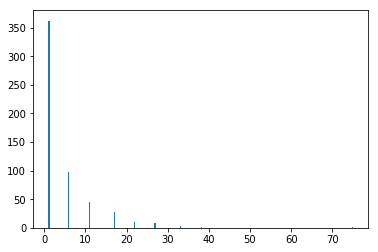

In [9]:
import pickle
import matplotlib.pyplot as plt

latent = pickle.load( open( "data.p", "rb" ) )
print(len(latent))
x = [len(l[0]) for l in latent]
plt.hist(x, bins=250)
plt.show()

In [10]:
%load_ext Cython

In [75]:
%%cython
import pickle
import numpy as np
import matplotlib.pyplot as plt
cimport numpy as np
import time

DTYPE = np.float
GAP_PENALTY = 10.0

cdef double euc(np.ndarray x, np.ndarray y):
    return np.sqrt(np.sum(np.square(x - y)))

cdef double min3(float x, float y, float z):
    cdef float minimum = x
    if y < minimum:
        minimum = y
    if z < minimum:
        minimum = z
    return minimum

cdef double dtw(np.ndarray x, np.ndarray y):
    cdef int n = x.shape[0]
    cdef int m = y.shape[0]
    cdef int w = max(round((n + m) / 10), abs(n - m) + 2)
    
    cdef np.ndarray dp = np.ones((n + 1, m + 1)) * float('inf')
    cdef int i,j
    dp[0,0] = 0.0
    for i in range(1, n + 1):
        for j in range(max(1, i-w), min(m + 1, i+w)):
            dp[i][j] = euc(x[i - 1, :], y[j - 1, :]) + min3(
                dp[i - 1][j - 1],
                GAP_PENALTY + dp[i - 1][j    ],
                GAP_PENALTY + dp[i    ][j - 1]
            )
    if np.isinf(dp[n][m]):
        print('\t\tERROR: inf in warping')
    return dp[n][m] / (n + m)

latent = pickle.load( open( "data.p", "rb" ) )
print(len(latent))
n = len(latent)
start = time.time()
cdef np.ndarray distances = np.ones((n, n)) * float('inf')
cdef int i,j
for i in range(0, n):
    if i % 10 == 0:
        end = time.time()
        print("\t{} / {} in {} [sec]".format(i, n, end - start))
        start = time.time()
    for j in range(i, n):
        x = latent[i]
        y = latent[j]
        if np.abs(len(x[0]) - len(y[0])) < 5:
            distances[i][j] = dtw(x[0], y[0])
pickle.dump(distances, open( "distances.p", "wb" ) )

556
	0 / 556 in 0.0022754669189453125 [sec]
	10 / 556 in 0.19964194297790527 [sec]
	20 / 556 in 0.21923184394836426 [sec]
	30 / 556 in 0.241379976272583 [sec]
	40 / 556 in 0.1447591781616211 [sec]
	50 / 556 in 0.1978437900543213 [sec]
	60 / 556 in 0.20783567428588867 [sec]
	70 / 556 in 0.16149544715881348 [sec]
	80 / 556 in 0.15022063255310059 [sec]
	90 / 556 in 0.15404272079467773 [sec]
	100 / 556 in 0.13394784927368164 [sec]
	110 / 556 in 0.14118361473083496 [sec]
	120 / 556 in 0.15190792083740234 [sec]
	130 / 556 in 0.14298129081726074 [sec]
	140 / 556 in 0.14258623123168945 [sec]
	150 / 556 in 0.12884116172790527 [sec]
	160 / 556 in 0.13837003707885742 [sec]
	170 / 556 in 0.13757538795471191 [sec]
	180 / 556 in 0.13482880592346191 [sec]
	190 / 556 in 0.1170036792755127 [sec]
	200 / 556 in 0.11469650268554688 [sec]
	210 / 556 in 0.11383628845214844 [sec]
	220 / 556 in 0.10460829734802246 [sec]
	230 / 556 in 0.11584997177124023 [sec]
	240 / 556 in 0.0888221263885498 [sec]
	250 / 556 

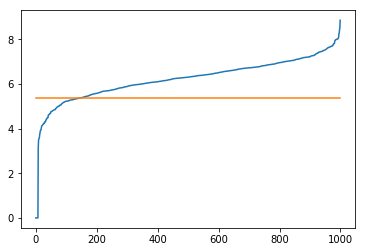

5.373010011514028
9.393783569335938


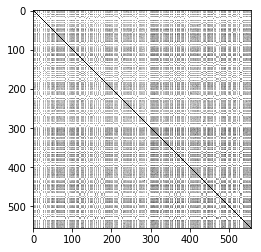

In [93]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random

latent    = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances.p", "rb" ) )

f = [f for f in distances.flatten() if not np.isinf(f)]
random.shuffle(f)
th = np.percentile(f, 15)

plt.plot(sorted(f[0:1000]))
plt.plot(np.ones(1000) * th)
plt.show()
print(th)
max_val = np.max([d for d in distances.flatten() if not np.isinf(d)])
print(max_val)
for i in range(len(distances)):
    for j in range(len(distances)):
        if np.isinf(distances[i][j]):
            distances[i][j] = distances[j][i]
        if np.isnan(distances[i][j]) or np.isinf(distances[i][j]):
            distances[i][j] = max_val
plt.imshow(distances, cmap='gray')
plt.show()

In [94]:
n = len([x for x in distances.flatten() if x < th])
print("Distances < {}: {} / {} = {}".format(th, n, len(distances.flatten()), n / len(distances.flatten())))

Distances < 5.373010011514028: 21036 / 309136 = 0.06804772009730345


In [95]:
pickle.dump(distances, open( "distances_normal.p", "wb" ))

In [96]:
import pickle
import matplotlib.pyplot as plt
latent = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances_normal.p", "rb" ) )

In [97]:
import sklearn
from sklearn.cluster import AgglomerativeClustering

In [98]:
ac = AgglomerativeClustering(
    n_clusters=None, 
    affinity='precomputed', 
    linkage='average', 
    distance_threshold=th
)
clusters = ac.fit_predict(distances)

In [99]:
c = [[] for i in range(len(set(clusters)))]
for i, cluster_id in enumerate(clusters):
    latent[i][1:][0]['cluster'] = cluster_id
    c[cluster_id].append(latent[i][1:][0])

In [100]:
final_clustering = [c for c in c if len(c) > 1 and len(c) < 800]
pickle.dump(final_clustering, open( "final_clustering.p", "wb" ) )
print(len(final_clustering))
print([len(c) for c in final_clustering])
print(sum([len(c) for c in final_clustering]))

91
[4, 5, 4, 2, 2, 2, 2, 3, 10, 2, 22, 2, 5, 2, 3, 2, 3, 2, 3, 2, 4, 2, 3, 2, 2, 3, 7, 3, 2, 5, 2, 2, 5, 112, 2, 2, 2, 3, 2, 3, 3, 2, 4, 3, 2, 2, 2, 2, 4, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 6, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
371


In [101]:
from scipy.io import wavfile
import sys
from google.cloud import storage
import pickle
import random 

final_clustering = pickle.load(open( "final_clustering.p", "rb" ))
print([len(c) for c in final_clustering])

print("CLUSTERS: ", len(final_clustering))

cache = {}
client = storage.Client.from_service_account_json('../secret.json')
bucket = client.get_bucket('wdp-data')

cx = 0
skip = 0
for cluster in final_clustering:
    if cx >= skip:
        n = len(cluster)
        print("Cluster: {} {}".format(n, cx))
        audio = []
        sampled_cluster = cluster.copy()
        random.shuffle(sampled_cluster)
        #sampled_cluster = sampled_cluster[:10]
        for i, region in enumerate(sampled_cluster):
            path = "audio_files/{}/{}".format(region['year'], region['filename'])
            if path in cache:
                stream = cache[path]
            else:                
                with open("/tmp/audio.m4a", "wb") as file_obj:
                    blob = bucket.blob(path)
                    blob.download_to_file(file_obj)
                stream = StreamSpectrogram("/tmp/audio.m4a", [region['start']], [region['stop']])
                cache[path] = stream              
                print(sys.getsizeof(cache))
            spec = fwd_spectrogram(stream.data[region['start']:region['stop']])
            audio.extend(stream.data[region['start']:region['stop']])
            audio.extend(np.zeros(stream.fs // 10))    
        audio = np.array(audio, dtype=audio[0].dtype)
        wavfile.write('../data/results/cluster_{}.wav'.format(cx), stream.fs, audio)
    cx += 1

Infile converted from .m4a to ".wav"
data read in!
864
Infile converted from .m4a to ".wav"
data read in!
864
Infile converted from .m4a to ".wav"
data read in!
864
Cluster: 2 11
Infile converted from .m4a to ".wav"
data read in!
864
Cluster: 5 12
Cluster: 2 13
Cluster: 3 14
Infile converted from .m4a to ".wav"
data read in!
864
Cluster: 2 15
Cluster: 3 16
Infile converted from .m4a to ".wav"
data read in!
864
Cluster: 2 17
Infile converted from .m4a to ".wav"
data read in!
864
Cluster: 3 18
Cluster: 2 19
Cluster: 4 20
Cluster: 2 21
Cluster: 3 22
Cluster: 2 23
Cluster: 2 24
Cluster: 3 25
Cluster: 7 26
Infile converted from .m4a to ".wav"
data read in!
1632
Cluster: 3 27
Cluster: 2 28
Cluster: 5 29
Cluster: 2 30
Infile converted from .m4a to ".wav"
data read in!
1632
Cluster: 2 31
Cluster: 5 32
Cluster: 112 33
Infile converted from .m4a to ".wav"
data read in!
1632
Infile converted from .m4a to ".wav"
data read in!
1632
Infile converted from .m4a to ".wav"
data read in!
1632
Infile conv

In [102]:
max_id = run_query("""
    SELECT 
        max(id)
    FROM 
        wdp_ds.clustering_results
    """)
if max_id[0]['max(id)'] is None:
    max_id = 0
else:
    max_id = max_id[0]['max(id)']
print(max_id)

4046


In [103]:
import pickle
final_clustering = pickle.load(open( "final_clustering.p", "rb" ))

with db.connect() as conn:
    id = max_id + 1
    for cluster in final_clustering:
        for r in cluster:
            query = "INSERT INTO wdp_ds.clustering_results VALUES({}, {}, '{}', {}, {}, '{}', {}, CURRENT_TIMESTAMP)".format(
                id, r['encoding'], r['filename'], r['start'], r['stop'], 'agglomerative_dtw_convnet_v5_1', r['cluster'])        
            conn.execute(query)  
            id += 1